# Logistic regression

```{note}
This chapter authored by [Todd M. Gureckis](http://gureckislab.org/~gureckis) is released under the [license](/LICENSE.html) for the book. 
```

In [2]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

from myst_nb import glue # for the Jupyter book chapter

The goal in this chapter is to build upon the previous chapter on linear regression to introduce the concept of **_logistic regression_**.  A very short summary is that while linear regression is about fitting lines, logistic regression is about fitting a particular type of "squiggle" to particular kinds of data.  We are going to talk first about why logistic regression is necessary, the types of datasets it applies to, then step through some of the details on fitting a logistic regression model and interpreting it.

Logistic regression is something you might not have heard about before in a psychology statistics course but it is becoming more common.  In addition, logistic regression is a very popular tool in data science and machine learning.

## Predicting binary outcomes

In much of the previous chapter we talked about regression in the context where we aimed to predict data that was on an interval scale (e.g., grumpiness given sleep).  However, often we are interested in a discrete, nominal outcome: a case where something happens or it doesn't.  We sometimes call these "binary" outcomes.

Examples include:

- predicting if someone will or will not graduate from high school
- predicting if someone will or will not get a disease
- predicting is a job applicant gets a “good” or “poor” rating on their annual review
- predicting if an infant will look at a stimulus or not in a looking time study
- predicting how a person will answer a true/false question

Each of these cases the thing that is being predicted is a dichotomous outcome with two levels or values (graduate/not, disease/no disease, good/poor, look/no look, true/false, etc..). These case come up enough in psychological research it is useful to know about the best way to approach the analysis of this data. 

I think a lot of students, fresh off the chapter on linear regression would just get to work trying to perform a normal linear regression on data where the predicted value is binary.  Why not?  It isn't like the statistics software (like `statsmodels`) will usually **stop** you from doing this.  Why do we need to learn an entirely different type of regression approach to handle these types of data?

## Why do we need logistic regression?

I'm about to show you the **wrong** way to analyze data with discrete, binary outcomes.  The reason is that doing this analysis the wrong way illustrates a bit why we need a different approach. 

```{caution} Don't get confused, this next section is not the right way to do things, and you will see why!
```

To make things concrete, imagine the following data set which contains some hypothetical data on the high school GPA of several students and if they were admitted to NYU (loaded from 'nyu_admission_fake.csv' in the current folder):

In [3]:
nyu_df = pd.read_csv('nyu_admission_fake.csv')
nyu_df

,student,gpa,admit
0,0,3.085283,1
1,1,0.083008,0
2,2,2.534593,1
3,3,2.995216,1
4,4,1.994028,0
5,5,0.899187,0
6,6,0.792251,0
7,7,3.042123,1
8,8,0.676443,0
9,9,0.353359,0


The `student` column is an anonymous identifier, `gpa` is the grade point average in high school on a 4.0 scale, and `admit` codes a binary variable about if the student was admitted to NYU (1=admit, 0=not admitted).  Taking what we learned from the last chapter let's conduct a typical linear regression analysis to assess how GPA influences if a student was admitted.

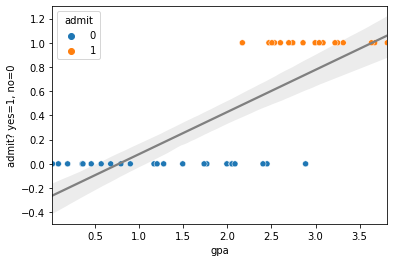

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  admit   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     56.45
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           5.02e-09
Time:                        12:38:28   Log-Likelihood:                -10.367
No. Observations:                  40   AIC:                             24.73
Df Residuals:                      38   BIC:                             28.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2671      0.105     -2.539      0.015      -0.480      -0.054
gpa            0.3479      0.046      7.513      0.000       0.254       0.442
==============================================================================
Omnibus:                        3.244   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.891
Skew:                          -0.576   Prob(JB):                        0.236
Kurtosis:                       2.360   Cond. No.                         5.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 432x288 with 0 Axes>

In [161]:
import statsmodels.formula.api as smf

lr=smf.ols(formula="admit ~ gpa", data=nyu_df).fit()

sns.regplot(x='gpa',y='admit', scatter=False,data=nyu_df, color='gray')
sns.scatterplot(x='gpa', y='admit', hue='admit', data=nyu_df)
plt.xlabel("gpa")
plt.ylabel("admit? yes=1, no=0")
plt.show()
fig=plt.gcf()

lr.summary()

Ok, so the first thing to note is that the regression worked!  The reason is that OLS linear regression is happy to regress on any numbers you give it.  However there's a few troubling things.  First the regression plot doesn't look like the line is doing that great a job.  Remember with linear regression we often focus on the *residuals*, how far the predictions of the line are from the real data.  If we do this for this dataset it looks like this:

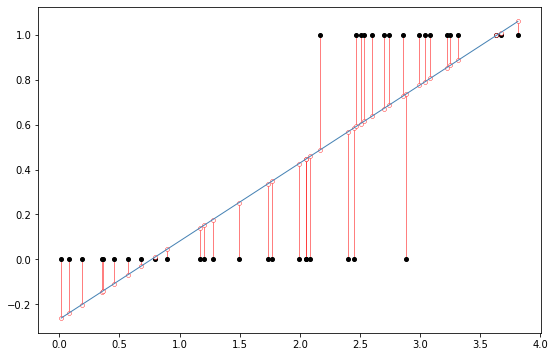

In [164]:
import statsmodels.formula.api as smf
import seaborn as sns

# fit a linear regression to the mpg column given hp
#display(fit.summary())

predict = lr.params['Intercept']+lr.params['gpa']*nyu_df.gpa
resid = nyu_df.admit-predict
fig, ax = plt.subplots(figsize=(9,6))

x1 = np.linspace(nyu_df['gpa'].min(), nyu_df['gpa'].max(),400)
y1 = lr.params['gpa']*x1+lr.params['Intercept']

ax.plot(nyu_df.gpa, nyu_df.admit,'ko',markersize=4)
ax.plot(nyu_df.gpa, nyu_df.admit-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')

ax.plot(x1,y1,'-',color='steelblue',linewidth=1)

ax.vlines(nyu_df.gpa, nyu_df.admit, nyu_df.admit-resid,'r',linewidth=0.5)
glue("resid2_fig",fig,display=False)

Which is kind of a sign of misspecified model (another way of saying using the wrong model/statistical technique).  The reason is that remember that one assumption of linear regression is *homogeneity of variance* which is the idea that the errors should be random and the same for all values of the input variable in simple linear regression.  If we plot the predicted values versus the residuals we should get a very well mixed cloud of points with no real patterns or correlation.  However, instead we get this weird striped pattern:

<AxesSubplot:>

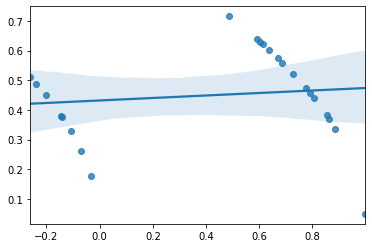

In [106]:
sns.regplot(lr.fittedvalues, np.sqrt(lr.resid))

which again looks like an error of some kind and violates on of the assumptions of the regression.

Furthermore, the models makes weird predictions.  Let's take a great student who has 2.5 GPA.  What would the predicted admission decision be for this person?

In [72]:
X_new = pd.DataFrame({'gpa': [2.5]})
lr.predict(X_new)

0    0.602731
dtype: float64

This is kind of hard to interpret.  Our model is saying if a person with a 2.5 GPA comes along our prediction about if they are admitted is 0.602.  Maybe that makes sense as a probability?  Like they have a probability of 0.6 to be admitted?  Ok but how about a student with a 4.0 GPA?

In [73]:
X_new = pd.DataFrame({'gpa': [4.0]})
lr.predict(X_new)

0    1.124653
dtype: float64

The probability of being admitted is 1.124!  This isn't a probability even because probabilities stop a 1.0 (1.0 is "certain").  Although you might be saying p=1.12 is **extra** certain it can't work that way and still be a probability, sorry.

In [74]:
X_new = pd.DataFrame({'gpa': [0.0]})
lr.predict(X_new)

0   -0.26714
dtype: float64

To top things off a student with a 0.0 GPA would have a -0.267 probability of admission.  This also makes no sense because probabilities can be less than 0.0.  And even if they could a negative probability means maybe they *do* have a 25% chance to get into NYU?  It's all a big mess and encourages us to do very bad and unreasonable things with the math.  **We do not want to do this, so we cannot use linear regression for this data**.

This is unfortunate because this kind of data is pretty common in psychology and many other areas of science as noted above.  So what can we do?

## Regression with probabilities

The last section kind of anticipated our solution... we really want to organize our thinking about this issue around probabilities.

Often we are not interested in predicting exactly these dichotomous outcomes but instead the *probability* of one or another outcome where there is a natural tradeoff between the two outcomes.  For instance if you are admitted to NYU you can't also not be admitted to NYU so the probabilities of these events a inversely related to one other.  The higher the likelihood you are admitted, the less likely you are not admitted.





Remember the canonical formula we had for a simple linear regression looked something like this:

$
Y_i = b_1 X_i + b_0 + \epsilon_i
$

where $\epsilon_i$ is the random residuals.

One might imagine, ok fine, let's let $Y_i$ just be the probability of some event (usually denoted $\pi$) and so we have

$
\pi_i = Y_i = b_1 X_i + b_0 + \epsilon_i
$

However there are a couple of problems with this approach, which is one interpretation we tried to apply above.  We didn't like it because it makes weird predictions (probabilities less or greater than 1.0 or 0.0) and looks like a terrible OLS fit.

More importantly we don't know how to compute the difference between the predicted outcome in our data because the data is unlikely to be probabilities but just a binary indicator of what happened.  To be clear, in our example,  we are interested if high school GPA is a good predictor of if people will be admitted to NYU.  What we observe in this case is values of the GPA ($X_i$ in the equation above) and also if the person is admitted (yes/no).  We do not know the *probability* that student 1 will be admitted, we only know that they did get admitted.  Thus if we tried to predict $\pi_i$ from the GPA all we can say is that the person did graduate and there is no "empirical" probability we can measure the error to.  

You might think we could make a guess about the probability by for instance binning the GPAs into ranges (e.g., 3.5-4.0) and counting the probability of admission in that bin compared to the (e.g., 2.5-3.0).  However, this abstracts away from the raw data and as a result loses some of the subtle variation in GPA scores that might be informative.  Logistic regression offers a clean way to do regression in this context.


In addition to this practical reason (no obvious ground-truth probability for least-squares regression), there are a few mathematical reasons why linear regression is inappropriate in this situation.  The first is that in a standard linear equation like this the value of $Y_i$ and thus the value of $\pi_i$ is not bounded between 0 and 1 (in fact it is unbounded such that the range of the predicted Y values can go from negative infinity to infinity).  As a result it is not a proper probability and thus mathematically wrong to do this.  Perhaps as a beginning student being mathematically wrong is not such a major concern for you but a key point is that choosing the "right" model for your data often pays off with cleaner and easier to interpret results.  The math is your friend here.  A second reason is that if we are truly predicting $\pi_i$ we have to realize that it is a binomial random variable and the variance will be a function of the value of $\pi$.  As you remember this is a violation of the assumptions of a traditional least-squares linear regression where we assume that there is equal variance across all values of the predictors.  

Given these mathematical and conceptual limitations of linear regression, we need to take a slightly different approach.

## The Logit Model

One way to model the relationship between a continuous predictor variable $X$ and a probability $\pi$ is with the logistic response function.  A plot of this function appears in {numref}`fig:sigmoid`.

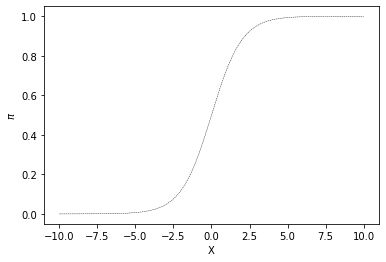

In [107]:
x=np.linspace(-10,10,200)
y=np.exp(x)/(1.0+np.exp(x))
plt.plot(x,y,'k--',linewidth=0.4)
plt.xlabel("X")
plt.ylabel("$\pi$")
fig=plt.gcf()
glue("sigmoid_fig",fig,display=False)

```{glue:figure} sigmoid_fig
:figwidth: 550px
:name: "fig:sigmoid"

Example of a logistic response function (also known as a sigmoid).
```

This is also know as a sigmoid or s-shaped curve.  Notice that the X value varies along a continuous range (here is plotted just between -10 and 10) but the y value ($\pi$) is bounded between 0 and 1.0.  As X increases the predictor value $\pi$ increases gradually up to one.  The sigmoid function is very important in many aspects of computational modeling exactly because of this bounded range.  One nice way to think about it is as a function that maps the real number line to a range bounded by 0 and 1.

Let's play with it a little to make sure everyone understands, we will put "in" a x value and get a y value "out".

If we put in a zero we get 0.5 for this particular sigmoid

In [81]:
x_in=0
y_out=np.exp(x_in)/(1.0+np.exp(x_in))
print(f'x_in is {x_in} and y_out is {y_out}')

x_in is 0 and y_out is 0.5


If we put in a really big number like 100 we get a number that will eventually to 1.0 but will never exceed it.  If you open this notebook chapter yourself in Jupyter you can play with it but you'll never get a number bigger than 1.0.

In [95]:
x_in=50
y_out=np.exp(x_in)/(1.0+np.exp(x_in))
print(f'x_in is {x_in} and y_out is {y_out:.9f}')

x_in is 50 and y_out is 1.000000000


On the other side you'll also never get a number less than 0 even with a very negative input:

In [96]:
x_in=-100
y_out=np.exp(x_in)/(1.0+np.exp(x_in))
print(f'x_in is {x_in} and y_out is {y_out:.9f}')

x_in is -100 and y_out is 0.000000000


So the logit function takes as input any number on the real number line and converts it to a number between 0.0 and 1.0 which would really be handy if you wanted to predict probabilities!

We can use this to modify our regression equation:

$
\pi = P(Y=1 | X=x_i) = \frac{e^{b_1 x_i + b_0}}{1.0+e^{b_1 x_i + b_0}}
$

if you multiply the left hand size by a special version of the number 1, (i.e., $\frac{e^{-(b_1 x_i + b_0)}}{e^{-(b_1 x_i + b_0)}}$) then you get 

$
\pi = P(Y=1 | X=x_i) = \frac{e^{b_1 x_i + b_0}}{1.0+e^{b_1 x_i + b_0}} \frac{e^{-(b_1 x_i + b_0)}}{e^{-(b_1 x_i + b_0)}}
$

$
\pi = P(Y=1 | X=x_i) = \frac{1}{1.0+e^{-(b_1 x_i + b_0)}} 
$

which is a slightly more common way to write a sigmoid function which I used above.


You can extend this easily to the mulitple regression case just by including more regressors in the exponential term:

$
\pi = P(Y=1 | X={x_n...x_1}) = \frac{1}{1+e^{-(b_n x_n + ... + b_1 x_1 + b_0)}} 
$

```{admonition} General Linear Models
In general, we can think about what we are doing here as applying a simple _function_ to the output of our normal linear regression.   If $Y_i$ is our equation for the simple linear regression:

$
Y_i = b_1 X_i + b_0 + \epsilon_i
$

we have

$
\pi_i = f(Y_i)
$

where $f()$ is a function sometimes known as a _linking function_ because it links the linear regression equation to the type of data we are modeling (in this case probabilities which are numbers between zero and one).

In the case of logistic regression the linking function, $f(x)$ is:

$
f(x) = \frac{1}{1+e^{-x}} 
$

which is the logistic function we just described.  There are several other linking functions that can be used depending on the type of data you are modeling.  For instance as we will encounter later, in fMRI data analysis it is common to combine linear regression with a special linking function called the _hemodynamic response function_ which models the biophysical response of the fMRI signal.  In general talking about regression with this output function $f(x)$ is known as the [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model).

```

## Log Odds

In general the equation above is somewhat bad news.  The first is that this equation is **non-linear** in terms of the predictors $x_n$.   This means we fall well outside the scope of linear regression!  However, this function has a special form that can be linearized by the logit transformation.  

```{hint}
**Linearization** in this case simply means rearranging the equation with algebra to solve for a slightly different form of the equation which is linear in the parameters.
```

Instead of prediction $\pi$ directly instead we predict $\pi/(1-\pi)$ which is the "odds ratio" of the predicted event happening compared to not happening (that is the $1-\pi$ term).

Since 

$
\pi = \frac{1}{1+e^{-(b_n x_n + ... + b_1 x_i + b_0)}} 
$

then

$
1-\pi =  \frac{1+e^{-(b_n x_n + ... + b_1 x_i + b_0)}}{1+e^{-(b_n x_n + ... + b_1 x_i + b_0)}} - \frac{1}{1+e^{-(b_n x_n + ... + b_1 x_i + b_0)}} 
$

$
1-\pi =  \frac{e^{-(b_n x_n + ... + b_1 x_i + b_0)}}{1+e^{-(b_n x_n + ... + b_1 x_i + b_0)}}
$

and then
$
\frac{\pi}{1-\pi} = e^{(b_n x_n + ... + b_1 x_i + b_0)}
$

(you can check the algebra yourself!)

If we take the natural log of both sides we get

$
ln(\frac{\pi}{1-\pi}) = b_0 + b_1 x_1 + ... + b_n x_n
$

Which is now a linear function of the parameters ($b_n$) and predictors ($x_n$).   The log odd ratio is known as the **logit**.  Interestingly, while $\pi$ ranges between 0 and 1 (a proper probability) the logit ranges between negative infinity and positive infinity making it an appropriate target for linear regression methods (we've fixed at least one of the math problems!).

Now, if your eyes are blurry from all this math yet, you might still be a little confused.  If you think back to what we did in our linear regression, our approach was to adjust the parameters of the equations (the $b_n$s) to minimize the sum of squared errors between the predicted and actual data for each data point.  Although the previous section got us to an equation which is linear in the parameter $b_n$ it is hard to imagine how we measure if this model predicts the data well.  One one hand we will have various yes/no values (i.e., yes the person with a 3.4 GPA graduated college) and this $ln(\frac{\pi}{1-\pi})$ logit predictor.  How do we connect the two in the same way that we estimated the squared error in the linear regression case?

The problem here is that the actual data in this case are, in log odds space, transformed to -inf and +inf.  The situation looks somewhat like this where we have our proposed "best fit line" and then when we try to compute the distance of each actual data point from the line we find that all points are infinite distance away in log odds space.  If we added them up, no matter what line we drew we would get the same sum of squared error so this approach will not work.

<img src="images/logodd-problem.png">




Lets use Python as a calculator to check what the issue is.  So imagine a person did get into NYU.  Then their log odd of addmition should be $log(\frac{1}{0}) = log(1)-log(0)$ but 

In [115]:
np.log(1)-np.log(0)

inf

So the log odds value of the data point here is +inf and the residual would then always be infinite. Same with the people who did not get into NYU who have $log(0/1) = log(0)$, but 

In [116]:
np.log(0)

-inf

This makes computing a typical "square residual" impossible in log odds space.  The solution takes advantage of the fact we are talking about probabilities.  In particular, logistic regression models are typically fit using the concept of maximum likelihood estimation (or MLE).  [Here](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is a Wikipedia entry on this.  The mechanics of it actually aren't that complex and we might as well run through them with a concrete example.

## Maximum Likelihood Fitting

Remember when we considered ordinary least squares regression (OLS) we came up with a way of "scoring" how well the line fits the data by summing up the squared residuals.  This gave us a "number" of how good a line we had found and then we searched around in the parameters to find the line which minimized the best fit.

We are going to do a similar thing with the log odds regression but instead of computing residuals we will instead convert the predicted values of the regression line into probabilities and compute the "likelihood" of the data under those probabilities.  We'll walk through an example here to make it more clear.

Let's start by reloading the hypothetical dataset we considered from the start of the chapter on admissions into NYU.

In [130]:
nyu_df = pd.read_csv('nyu_admission_fake.csv')
nyu_df

,student,gpa,admit
0,0,3.085283,1
1,1,0.083008,0
2,2,2.534593,1
3,3,2.995216,1
4,4,1.994028,0
5,5,0.899187,0
6,6,0.792251,0
7,7,3.042123,1
8,8,0.676443,0
9,9,0.353359,0


Now lets plot the admission decision as a function of high school GPA:

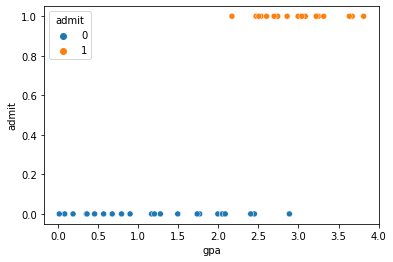

In [133]:
sns.scatterplot(x='gpa',y='admit',hue='admit',data=nyu_df)
plt.show()

As expected that data on the y-axis fall into a dichtomous variable, but generally it looks like a higher GPA makes it more likely you are admitted.

As mentioned before we actually will be fitting the line not in the space of $p(admitted)$ but in the *log odds* of being admitted (i.e., $log(p/1-p)$).

To begin with let's propose a particular linear regression line in the log-odds space.  To do this we need to chose values of the slope and intercept for the line.  For now lets just throw out a first pass of setting the slope to 2.0 and the intercept to -3.  Just like how when we started with linear regression we said we could try particular values of the parameters of the line and kind of "wiggle" them around to find a proper setting.

So here is our line plotted in log-odds space:

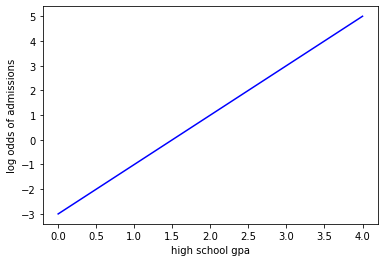

In [165]:
x = np.linspace(0,4.0,200)
y = 2.0*x-3
plt.plot(x,y,'b-')
plt.xlabel('high school gpa')
plt.ylabel('log odds of admissions')
plt.show()

Rather than compute the residuals (as above we said those were all infinite).  Instead what we do is project the data onto our log odds line to compute the predicted log odds of admissions for each data point under our current linear regression model.  Then we transform this back into probability space as shown in the following figure:

<img src="images/logodd-transform.png">

The panel on the right show a proposed line in our log odds space.  This function is used to get a predicted log odds value for each data point (only four are shown here through the linear projection).  Then the log odds value is converted into a probability using the equation shown 

$
p = \frac{e^{log(odds)}}{1+e^{log(odds)}}
$

which is basically just an inversion of the logic we used above to get the log odds in the first place.  We can then plot this in the original probability space (left panel) and it has this nice sigmoid shape which looks like a roughly nice fit to the data at least to start.


The reason it looks nice is that it assigned higher probability to admissions when the GPA is higher.  Of course it misses a few cases for example the person with the extremely low GPA who still was admitted and the few cases of a very high GPA where people still were not admitted.

```{admonition} Inverting the log odds
For those that want more proof about the equation for converting log odds into probabilities...

We started with defining log odds as:
$
log(\frac{\pi}{1-\pi}) = log(odds)
$

first exponentiate both sides
$
\frac{\pi}{1-\pi} = e^{log(odds)}
$

then multiply both sides by $(1-\pi)$:
$
\pi = (1-\pi)*e^{log(odds)}
$

then distribute the $e^{log(odds)}$:
$
\pi = (e^{log(odds)}-\pi*e^{log(odds)})
$

move one term to the other side:
$
\pi + \pi*e^{log(odds)} = e^{log(odds)}
$

pull the $\pi$ out:
    
$
\pi * (1 + e^{log(odds)}) = e^{log(odds)}
$

then divide both sides:
$
\pi = \frac{e^{log(odds)}}{(1 + e^{log(odds)})}
$
```

Let's try this with python.  So our linear equation is $y = 2.0*x-3$ in log odds space.  So we can use this to get a predicted log odd for each student.  We will add this as a new column to our dataframe:

In [142]:
nyu_df['log_odds']=2.0*nyu_df['gpa']-3
nyu_df

,student,gpa,admit,log_odds
0,0,3.085283,1,3.170565
1,1,0.083008,0,-2.833984
2,2,2.534593,1,2.069186
3,3,2.995216,1,2.990431
4,4,1.994028,0,0.988056
5,5,0.899187,0,-1.201627
6,6,0.792251,0,-1.415497
7,7,3.042123,1,3.084246
8,8,0.676443,0,-1.647113
9,9,0.353359,0,-2.293281


Next we want to convert the log-odds into a probability using the equation we just described.  Let's make a new column for "predicted probability":

In [144]:
nyu_df['pred_p']=np.exp(nyu_df['log_odds'])/(1+np.exp(nyu_df['log_odds']))
nyu_df

,student,gpa,admit,log_odds,pred_p
0,0,3.085283,1,3.170565,0.959711
1,1,0.083008,0,-2.833984,0.055515
2,2,2.534593,1,2.069186,0.887872
3,3,2.995216,1,2.990431,0.952140
4,4,1.994028,0,0.988056,0.728704
5,5,0.899187,0,-1.201627,0.231186
6,6,0.792251,0,-1.415497,0.195368
7,7,3.042123,1,3.084246,0.956238
8,8,0.676443,0,-1.647113,0.161499
9,9,0.353359,0,-2.293281,0.091681


Ok now we can plot our predicted probabilities along with the actual data:

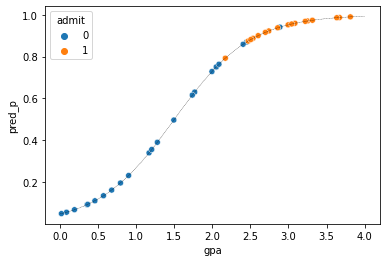

In [153]:
x = np.linspace(0.0,4.0)
y = 1/(1+np.exp(-2.0*x+3))
sns.scatterplot(x='gpa',y='pred_p',hue='admit',data=nyu_df)
plt.plot(x,y,'k--',linewidth=0.3)

The line here is the logistic fit of our model and the colored dots show the data.  The overall fit looks reasonable because it is giving a high predicted probability (`pred_p`) to people who were admitted.  However, is this the best we can do?  To search for better parameters we need a way to "score" how good of a fit to the data this is.  We can use this using likelihood.  So lets compute the likelihood of the data given this particular logistic curve.


### Intuition of computing the likelihood

There are more formal approaches to defining maximum likelihood estimation but lets just use intuition here.  We can think of a binary prediction as predicting the outcome of a coin toss.  If we have a fair coin (i.e., one that has equal probability of heads and tails) then the probability of say "heads" is 0.5 on a single flip.  We can consider this probability the _likelihood_ of getting a heads.  

<img src="./images/coinflip.png" width="150">

Let's write this down using some notation to make it easier to build up.  We will call the underlying probability of getting a heads $\theta$ and we assume with a fair coin this is 0.5.  Now we can talk about the _likelihood_ of getting a particular event or data $d$.  For instance the probability of getting a single coin flip to turn up heads could written:

$
p(d=heads|\theta = 0.5)=\theta = 0.5
$

Notice the `|` symbol in the equation which means "given".  So what this simple line says is the probability of getting our "data" to be a single heads given the underlying probability of getting heads is 0.5 is, you guessed it, 0.5.

How about if the coin flip came up tails?  Then we would have:

$
p(d=tails|\theta = 0.5) = (1-\theta) = 0.5
$


We talk about the expressions here $p(d|\theta)$ as the *likelihood* of the event.


Ok, what if $\theta$ was different than 0.5?  Imagine a coin was a trick coin that was somehow modified to be slightly heavier on one side it might bias it to one or another outcome.  For example, imagine we change the coin so that it has a 0.7 probability of getting heads.  Then if we see a heads from this coin the _likelihood_ of this event is 0.7 (i.e., $\theta=0.7$).  In contrast if we flip a tails the probability/likelihood of that events is (1-0.7)=0.3.  In other words, the likelihood of getting a tails is 0.3.  Formally

$
p(d=heads|\theta = 0.7)=\theta = 0.7
$

and

$
p(d=tails|\theta = 0.7) = (1-\theta) = 0.3
$

So the probability of a binary event like heads/tails is a function of the outcome and the probability we assigned to that outcome.

Now, where this all comes together is that we can think of the `pred_p` value we just computed as the probability assigned to each student of being admitted. In other words `pred_p` is the $\theta$ on this coin.   Imagine our model predict that student $s$ has a 0.76 probability of getting into NYU given their GPA.  If they _do_ get in then:

$
p(d_s=admit_s | \theta_s=0.76) = 0.76
$

and if they don't get in we assign that a lower probability of happening given their GPA

$
p(d_s=reject_s | \theta_s=0.76) = 0.24
$


This is where the regression element come in.  We want to move the parameters of our regression line to that we **maximize the likelihood** of the data.  Meaning, we want to try to assign higher probabilities to things that happened and low probabilities to things that didn't.  Our main limitation here is that we are using the sigmoid function and so generally we have this kind of s-shaped squiggle and we want to adjust it to match the data.  In an ideal case we could assign `pred_p` = 1.0 to only the student who were admitted and `pred_p`=0.0 to all the students who were not admitted only based on their GPA.  This is difficult because in our dataset there doesn't appear to be some GPA threshold that was used for admissions, so all we can do is see that admission probabilities go up somewhat with higher GPA but we don't know exactly how to fit this.

So, to summarize where we are so far, we understand that the logistic regression curve will assign a "probability" of some event happening to each item in our dataset (using the mechanics of linear regression in log-odd space and so forth).  We want to try "wiggling" the parameters of the regression around so that we assign high probabilities to things that actually happen (i.e., students who were admitted) and low probabilities to things that didn't actually happen (i.e., students who were not admitted).  Our hands are tied in one way which is that since we are using a logistic regression model we generally can only adjust this s-shaped probability curve.  



### Fitting all the data with the joint likelihood

Ok but there is still two pieces missing.  The first is how do we assess _all_ the students at once.  The model predicts a logodds for each student in our data set, which we convert to a probability.  But then we want to do this for all the students in our data set together.  In other words we aren't assessing the probability of one coin event we are doing it for all the coin flips associated with each student in our dataset.  Luckily the probability of a bunch of independent data is simply the multiplication of all the probabilities (you can read it in your head as what is the probability of student 1 having such and such outcome **AND** student 2 having such and such outcome **AND** student 3 having such and such outcome, etc...).

Let's denote the entire dataset as a capital $D$ (as opposed to the small $d$ we used for the individual data points).  Then

$
p(D|model) = p(d_0 | \theta_{0,model}) * p(d_1 | \theta_{1,model}) * p(d_2 | \theta_{2,model}) ...
$

here $\theta_{0,model}$ means the probability that student 0 is admitted given the current regression model. If student was admitted we set the probability of that student's outcome equal to the the probability the logistic model assigned.  If a student was not admitted, but we assigned a high probability then we set probability of them _not_ being admitted is 1-`pred_p`.  This gives us the likelihood of a single data point/student given our logistic regression model.  We can write more simply like this:

$
p(D|model) = \prod_s p(d_s | \theta_{s,model})
$

However, more often we are interested in the log likelihood (logs really do show up a lot in this chapter!).  The log of the likelihood is nice because if we multiply a bunch of small probabilities together, Python can often return a numeric error.  Thus if we first take the log, we can instead add the numbers up.  So we end up with

$
log(p(D|model)) = log(p(d_0 | \theta_{0,model})) + log(p(d_1 | \theta_{1,model})) + log(p(d_2 | \theta_{2,model})) + ...
$

which can be written:

$
log(p(D|model)) = \sum_s log(p(d_s | \theta_{s,model}))
$


So the log likelihood in this formula plays a similar role to the least-squares error we used in standard regression.  We want to maximize this value (meaning increase the likelihood of the data given the model) by adjusting the parameters of our logistic regression.

Before computing this by hand, let's just think about a few consequences for some simple data.

In [171]:
example_df=pd.DataFrame({'student':[1,2,3,4,5,6], 'outcome':[0,0,0,1,1,1], 'probability': [0,0,0,1,1,1]})
example_df

,student,outcome,probability
0,1,0,0
1,2,0,0
2,3,0,0
3,4,1,1
4,5,1,1
5,6,1,1


In this example data set we have six students, a binary 'outcome' measure, and a probability which we could assume come from some model like our logistic regression.  We want to know the likelihood of the outcomes given these probabilities.  If you look at the data closely you can see that the model is perfect... is assign 1.0 probability to each case where the actual outcome was 1 and 0 to the cases where the outcome was 0.  This is the best possible model.  What is the $log(p(D|model))$?

First lets consider the cases where the outcome was 1, take the log of the probability column and add them up:

In [180]:
part1=np.log(example_df[example_df['outcome']==1]['probability']).sum()
part1

0.0

Next, lets do the same thing for the case where the outcome was 0.  However here we need to take the log of 1-probability because our model is predicting when the outcome will occur:

In [181]:
part2=np.log(1.0-example_df[example_df['outcome']==0]['probability']).sum()
part2

0.0

Then we just add these two value together to get the total log likelihood of the data:

In [183]:
part1+part2

0.0

Alright so the log likelihood here is zero, which is the best we can possibly hope for.  To convert this back to a probability we just raise it to e:

In [184]:
np.exp(part1+part2)

1.0

And so we can see the probabilty of the data given the model is 1.0 which means the data are **certain** under the model.  Wow!  Great job.

Let's consider another case where instead of getting the probabilities perfectly right we get them perfectly wrong (assign high probability to events that don't happen and low probability to events that do):

In [188]:
example_df=pd.DataFrame({'student':[1,2,3,4,5,6], 'outcome':[0,0,0,1,1,1], 'probability': [1,1,1,0,0,0]})
print(example_df)
part1=np.log(example_df[example_df['outcome']==1]['probability']).sum()
part2=np.log(1.0-example_df[example_df['outcome']==0]['probability']).sum()
print(f"log likelihood is: {part1+part2}")
print(f'likelihood is: {np.exp(part1+part2)}')

   student  outcome  probability
0        1        0            1
1        2        0            1
2        3        0            1
3        4        1            0
4        5        1            0
5        6        1            0
log likelihood is: -inf
likelihood is: 0.0


I did all the calculations this time in one cell block so step through and make sure you understand the output.  Notice how the log likelihood is negative infinity in this case (very far from zero which was the maximum we saw in the previous example).

One final case where the model is really unsure and so just assigns 0.5 probability to everyone:

In [190]:
example_df=pd.DataFrame({'student':[1,2,3,4,5,6], 'outcome':[0,0,0,1,1,1], 'probability': [0.5,0.5,0.5,0.5,0.5,0.5]})
print(example_df)
part1=np.log(example_df[example_df['outcome']==1]['probability']).sum()
part2=np.log(1.0-example_df[example_df['outcome']==0]['probability']).sum()
print(f"log likelihood is: {part1+part2}")
print(f'likelihood is: {np.exp(part1+part2)}')

   student  outcome  probability
0        1        0          0.5
1        2        0          0.5
2        3        0          0.5
3        4        1          0.5
4        5        1          0.5
5        6        1          0.5
log likelihood is: -4.1588830833596715
likelihood is: 0.015625000000000007


So you can see there is log likelihood is -4.16 and the overall likelihood of the data remains low (0.015).  This shows how different assignments of probabilities to the data implies different likelihoods and therefore "fits".  Let's try it now for our regression model:

In [191]:
part1=np.log(nyu_df[nyu_df['admit']==1]['pred_p']).sum()
part2=np.log(1.0-nyu_df[nyu_df['admit']==1]['pred_p']).sum()
print(f"log likelihood is: {part1+part2}")
print(f'likelihood is: {np.exp(part1+part2)}')

log likelihood is: -52.62649758803535
likelihood is: 1.395090867057656e-23


Ok so here the log likelihood is -52.626.  Can we do better?  To try we need to adjust the parameters our regression to find ones that give a higher (less negative) log likelihood.

As you know now we could search around for better parameters by hand (or write our own python function to do this) but it turns out the statistical packages for Python provide a simple way to fit these models so in the next section we will learn to use them.

```{admonition} Followup video
This is a great and instructive video about maximum likelihood estimation: [https://www.youtube.com/watch?v=BfKanl1aSG0](https://www.youtube.com/watch?v=BfKanl1aSG0)
```

## Fitting logistic regression models

There are several packages that provide logistic regression fitting and summarizing routines in Python.  The one most similar to what we learned about with linear regression is `statsmodels` and so we will begin there.  However, later we will also quickly learn how to use `scikit-learn` a machine learning package because of some of the issue we will explore later in the chapter.

Let's perform the logistic regression on the NYU admissions data.  It operates similar to the ordinary least square (OLS) regression.  We need to first import two modules from the `statsmodels` package.  Instead of `smf.ols()` which we used for OLS regression we just change the command to `smf.logit()`:

In [198]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

logitfit = smf.logit('admit ~ gpa', data=nyu_df).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.213802
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Jan 2021   Pseudo R-squ.:                  0.6864
Time:                        10:45:16   Log-Likelihood:                -8.5521
converged:                       True   LL-Null:                       -27.274
Covariance Type:            nonrobust   LLR p-value:                 9.406e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4491      4.842     -2.571      0.010     -21.939      -2.959
gpa            5.1953      1.970      2.637      0.008       1.334       9.057
==============================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

A couple of notes here, about the output.  First notice the output `summary()` provides include the `Log-likelihood` which is -8.551.  This is a much better (larger) likelihood than the -52.626 we found by hand above and is not surprising because the parameters we used earlier we just randomly chosen and were not "fit" with any particular goal in mind.

## Interpreting the fits

Fitting a logistic regression is fun but pointless unless we are going to interpret the fit of the model!  We learned about interpreting the coefficients, corresponding hypothesis tests, and issues in overall model fit in the chapter on linear regression.  In order to provide the same interpretation to a logistic regression we need to learn a few other things because the interpretation is a little different.

### Interpretting overall fit quality

If you remember from our discussion about linear regression, the first question we had after fitting a model is "Is this model any good?"  To answer that we turned to the $R^2$ value which computes the percentage of the total variation in the output explained by the regression model.  To do this we compared the total sum of squared error of the "output" variables around their mean to the residuals from the linear regression line.  However, as the above discussion about **fitting** the logistic regression model anticipates, we can't count on standard residuals in this case because they are infinite in the log-odds space.

Instead there are several different metrics that people use to assess how "well" a logistic regression model accounts for a data set.  Perhaps the most common is pseudo-$R^2$ which is a measure of the proportional log odds improvement of the fitted logistic regression compared to a model which only includes an intercept but no slope.

You can see that in the regression we did above the pseudo-$R^2$ value is 0.6864.  Generally speaking we want this value to be closer to 1.0 than to 0.0.  The formula for this value (also known as McFadden's pseudo-$R^2$) is:

$
R^2 = 1 - \frac{ln L(M_{full})}{ln L(M_{null})}
$

here the term $L(M_{null})$ refers to the likelihood of a model with only an intercept term but not slope.  This is computed already for us in the output of the `statsmodels` `logit()` fitting routine (see `LL-null` in the output).

so in our case:

In [7]:
r_sq = 1.0 - (-8.5521/-27.274)
print(r_sq)

0.6864376329104642


which is exactly what we found for the pseudo-$R^2$.  

You can easily prove to yourself that `LL-null` in the output corresponds to a model with no slope by fitting such a model yourself: 

In [8]:
logitfit = smf.logit('admit ~ 1', data=nyu_df).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.681855
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                   40
Model:                          Logit   Df Residuals:                       39
Method:                           MLE   Df Model:                            0
Date:                Sun, 24 Jan 2021   Pseudo R-squ.:               1.708e-10
Time:                        00:54:25   Log-Likelihood:                -27.274
converged:                       True   LL-Null:                       -27.274
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3023      0.320     -0.945      0.345      -0.929       0.325
==============================================================================
"""

Note that in this case the `Log-likelihood` and `LL-null` is the same thing.

Although pseudo-$R^2$ has a similar profile to the $R^2$ we considered with OLS regression, the interpretation is a little more complex.  As a result, people often prefer a different measure of how good a logistic regression model "fits."

One very natural one is just to see how accurate the model is.  Imagine we find the model's predicted probability for each data point.  Then we assume that anytime $p>=0.5$ we should guess "yes" and anytime is it $p<0.5$ we should predict "no".  We can compare these guesses from the model to the actual data we fitted to to obtain a within-sample accuracy score.  Ideally we would want this number to be high (closer to one) and a model that, even after fitting, is getting a low accuracy would be a sign that the data is either very noisy or not a good fit to the logistic.

Let's try this for the example above:

First we fit the model like above:

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

logitfit = smf.logit('admit ~ gpa', data=nyu_df).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.213802
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Jan 2021   Pseudo R-squ.:                  0.6864
Time:                        14:35:59   Log-Likelihood:                -8.5521
converged:                       True   LL-Null:                       -27.274
Covariance Type:            nonrobust   LLR p-value:                 9.406e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4491      4.842     -2.571      0.010     -21.939      -2.959
gpa            5.1953      1.970      2.637      0.008       1.334       9.057
==============================================================================

Possibly complete quasi-separation: A fraction 0.17 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

then we just find the predictions for each data point using `logitfit.predict()` and see which of these are greated at 0.5.  Then are compare that the the `admit` column of our fitted nyu dataset and compute the mean.

In [15]:
np.mean(nyu_df['admit']==(logitfit.predict()>=0.5))

0.9

With this we find that the accuracy is 90\% which is a good sign.  However, there is a risk with an accuracy score like this being too optimistic about how good of a model we have.  We'll discuss the issues in evaluating the predictive performance of a model on the data it was fitted to below.

### Interpretting coefficients

As we did for linear regression, we can also try to interpret the meaning of the fitted regression coefficients in a logistic regression model.    The interpretation of these terms is less straight forward than in regular linear regression because of the nonlinearity introduced by the sigmoid.  Usually we like to talk about how the regression coefficient means for each single unit increase in the input variable there is a corresponding increase in the output prediction.  However, the increase in predicted probability is nonlinear in a logistic regression.  A unit increase in some areas of the input space might result in a larger increase than a increase in a region closer to 0 or 1.  

One important thing to note about the typical output of the regression, and the approach used by `statsmodels` is that the coefficients are the ones of the linear regression in the log-odds space rather than in the original probability space.  For example, in the grade example above the intercept is -12.4491.  This means that if a person had a zero GPA, they would have a very negative log odds of being admitted to NYU.  Unfortunately the deck would be stacked against you in that case.  The standard error and z-score are what is used to compute a probability for the hypothesis test that this intercept is different than zero.  In this example we are able to reject that null hypothesis because the p value is 0.01. Typically the intercept is ignored in logistic regression, except in special cases. 

The estimated slope is 5.1953.  This means that for every one GPA unit gained the log odds of being admitted to NYU increases by 5.1953.  Again the output includes a hypothesis test on the coefficient asking if this is significantly different than zero (and we reject the null hypothesis of a zero slope because the p-value is 0.008 which is less than 0.05).

Interpreting changes in the output prediction in terms of log odds can be difficult, and people often prefer directly in terms of probabilities (which is possible via the transformations described above).  However, due to the nonlinearity of the logistic function, the rate of change is highest near the inflection or turning point (which is near the mean of the output data) because that is the part that has the highest tangent (i.e., first derivative).  Thus often people report the change in the probability of the outcome variable as a function of the maximum possible change (basically an upper estimate of what it could be) by using the derivative at this point.  I won't go into the details of that here, but the book on regression by Gelman and Hill provides a useful starting point.

## Logistic regression for a discrete variable

In the previous example we have focused on fitting a logistic regression model where the input predictor was continuous (gpa) and the output was discrete (accepted to NYU or not).  Another interesting use of logistic regression is to model a discrete variable, such as would be the case when predicting the effect of a experimental treatment.  For example, imagine we did an experiment where we randomly assigned high school students to a college-entrance tutoring course or to a course on improving writing skills and were are interested in which treatment results in more students being admitted to college.

## Classification 

## Summary

Ok, we've come a long way and covered a lot of the details about regression, perhaps more than you will need for the labs but hopefully something you can come back and refer to sometime in the future.

We covered: 
- Basic ideas in linear regression and how regression models are estimated.
- Multiple linear regression.
- Measuring the overall performance of a regression model using $R^2$
- Hypothesis tests for regression models
- Calculating confidence intervals for regression coefficients, and standardised coefficients 
- The assumptions of regression and how to check them 
- Selecting a regression model (aka variable selection)

## Further Reading

- [Guide to an in-depth understanding of logistic regression](https://www.dataschool.io/guide-to-logistic-regression/)
- [StatQuest: Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8) - nice youtube channel on many stats concepts
- [StatQuest: Maximum Likelihood](https://www.youtube.com/watch?v=BfKanl1aSG0)
- [Interpreting odds ratio in logistic regression](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/)
